# Adapt the variational auto encoder

Below you will find an implementation of a VAE for the MNIST data. To allow for faster learning time, we only consider the digits 0,1, and 2 and only the first 100 samples of those digits.

In this exercise, you should familiarize yourself with the implementation below and experiment with the structure of the VAE specification in order to emphasize digit separation in the latent space and the generation of images when sampling from the latent space.

Part of the implementation is based on code from the official Pyro examples.

In [1]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import datetime
import os
import matplotlib.gridspec as gridspec
from matplotlib import pyplot
import matplotlib.pyplot as plt
from scipy.stats import norm

### Get the MNIST data

We will wrap the MNIST data set in a Pyro data loader. 

In [2]:
def setup_data_loader(batch_size=64):
    #data = datasets.MNIST('./data', train=True, download=True,
    #                      transform=transforms.Compose([
    #                          transforms.ToTensor(),
    #                          transforms.Normalize((0.1307,), (0.3081,))
    #                      ]))
    data = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
    
    # We only select the digits 0, 1, and 2 and only the first 100 of each of these
    # digits
    selector = np.array([], dtype=int)
    for i in [5, 6, 7]:
        selector = np.concatenate((selector, np.where(data.targets == i)[0][:100]))
    data.data = data.data[selector, :, :]
    data.targets = data.targets[selector]
    
    # Binarize the data
    data.data[data.data<128] = 0
    data.data[data.data>=128] = 1

    data.data = data.data.type(torch.float)
    
    # Put the data within a data loader 
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    return train_loader


train_loader = setup_data_loader(batch_size=300)

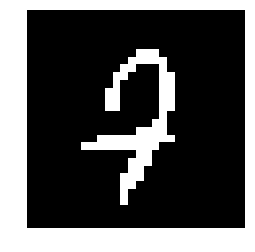

In [3]:
def display_image(x):
    plt.axis('off')
    pyplot.imshow(x.reshape((28, 28)), cmap="gray")
    
toy_image = train_loader.dataset.data[215,:,:]
display_image(toy_image)

### Setup the decoder network

In [4]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        #loc_img = self.sigmoid(self.fc21(hidden))
        loc_img = self.fc21(hidden)
        return loc_img

### Setup the encoder network

In [5]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

### Packaging it all together

In [6]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=2, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(logits=loc_img).to_event(1), obs=x.reshape(-1, 784))
            #pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

    def sample_images(self, dim=10):

        plt.figure(figsize=(dim, dim))
        gs1 = gridspec.GridSpec(dim, dim)
        gs1.update(wspace=0.025, hspace=0.05)  # set the spacing between axes.

        z_1 = norm.ppf(np.linspace(0.00001, 0.99999, dim), loc=0, scale=1)
        z_2 = norm.ppf(np.linspace(0.00001, 0.99999, dim), loc=0, scale=1)
        for j in range(dim):
            for i in range(dim):
                x_val = self.decoder.forward(torch.tensor([z_1[i], z_2[j]], dtype=torch.float32))
                plt.subplot(gs1[i*dim+j])
                plt.axis('off')
                plt.imshow(x_val.detach().numpy().reshape((28, 28)), cmap="gray_r")
        plt.show()

### Setup training (single epoch)

In [7]:
def train(svi, train_loader):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

### Perform learning

[epoch 000] average training loss: 561.9964
[epoch 100] average training loss: 20.7505
[epoch 200] average training loss: 19.0819
[epoch 300] average training loss: 18.7468
[epoch 400] average training loss: 18.1215
[epoch 500] average training loss: 17.7618
[epoch 600] average training loss: 17.4973
[epoch 700] average training loss: 17.4621
[epoch 800] average training loss: 17.3345
[epoch 900] average training loss: 17.1521


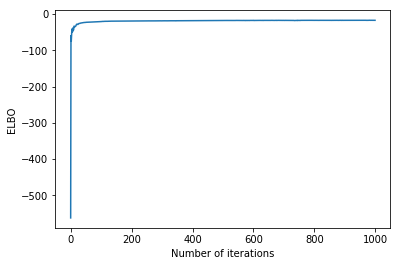

In [8]:
vae = VAE(z_dim=2, hidden_dim=400)

# Run options
LEARNING_RATE = 1.0e-2

# Run only for a single iteration for testing
NUM_EPOCHS = 1000

#train_loader = setup_data_loader(batch_size=300)

# clear param store
pyro.clear_param_store()

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
train_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader)
    train_elbo.append(-total_epoch_loss_train)
    if (epoch % 100) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, total_epoch_loss_train))

plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()

### Plot the data in the embedding space

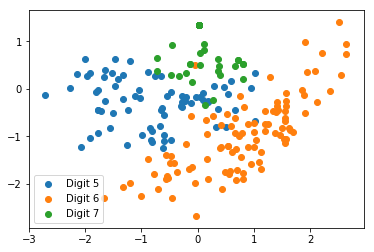

In [9]:
for x, x_l in train_loader:
    z_loc, z_scale = vae.encoder(x)

legends = ["Digit 5", "Digit 6", "Digit 7"]
z_loc = z_loc.detach().numpy()
for idx, i in enumerate([5,6,7]):
    plt.scatter(z_loc[x_l.numpy()==i,0], z_loc[x_l.numpy()==i,1], label=legends[idx])
plt.legend()
plt.show()